In [15]:
%pip install transformers sentence-transformers torch torchvision torchaudio scikit-learn pandas tqdm umap-learn shap lime gradio


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from transformers.utils import logging
logging.set_verbosity_error()

import torch
import pandas as pd
import numpy as np
from transformers import pipeline
from sentence_transformers import SentenceTransformer


In [ ]:

# Expected CSV: at least a column named 'text'. Optionally 'label' if you have a test set.
DATA_PATH = "Dataset.csv"   # <--- replace with your file
df = pd.read_csv(DATA_PATH)
if 'text' not in df.columns:
    raise ValueError("CSV must contain a 'text' column")
print("Loaded", len(df), "rows. Sample:")
df[['text']].head(3)


Loaded 10 rows. Sample:


,text
0,"Breaking: The moon is made of cheese, says ano..."
1,The WHO confirmed that vaccines are safe and e...
2,"Aliens have signed a treaty with the UN, accor..."


In [ ]:

MODEL = "joeddav/xlm-roberta-large-xnli"
zero_shot = pipeline("zero-shot-classification", MODEL, device=DEVICE)


candidate_labels = ["fake", "real"]
hypothesis_template = "This article is {}."

def batch_zero_shot(texts: List[str], labels=candidate_labels, hypothesis_template=hypothesis_template, batch_size=16):
    outputs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        res = zero_shot(batch, candidate_labels=labels, hypothesis_template=hypothesis_template)
        if isinstance(res, dict):
            res = [res]
        outputs.extend(res)
    return outputs

sample_texts = df['text'].astype(str).tolist()[:50]
sample_out = batch_zero_shot(sample_texts, batch_size=8)
print(sample_out[0])


{'sequence': 'Breaking: The moon is made of cheese, says anonymous source.', 'labels': ['fake', 'real'], 'scores': [0.9895133972167969, 0.01048661582171917]}


In [ ]:

texts = df['text'].astype(str).tolist()
bs = 32
results = batch_zero_shot(texts, batch_size=bs)

top_labels = [r['labels'][0] for r in results]
top_scores = [r['scores'][0] for r in results]
prob_vecs = [dict(zip(r['labels'], r['scores'])) for r in results]

df['zs_top_label'] = top_labels
df['zs_top_score'] = top_scores
df['zs_probs'] = prob_vecs

df[['text','zs_top_label','zs_top_score']].head()


,text,zs_top_label,zs_top_score
0,"Breaking: The moon is made of cheese, says ano...",fake,0.989513
1,The WHO confirmed that vaccines are safe and e...,real,0.817507
2,"Aliens have signed a treaty with the UN, accor...",fake,0.920798
3,The stock market rose today after positive eco...,real,0.599833
4,"Drinking bleach can cure coronavirus, claims v...",fake,0.835588


In [ ]:

CONF_THRESH = 0.6
df['zs_pred'] = df['zs_top_label']
df['zs_pred_uncertain'] = df['zs_top_score'] < CONF_THRESH
df['zs_pred_final'] = df.apply(lambda r: 'uncertain' if r['zs_pred_uncertain'] else r['zs_pred'], axis=1)

df[['zs_top_score','zs_pred_final']].head()


,zs_top_score,zs_pred_final
0,0.989513,fake
1,0.817507,real
2,0.920798,fake
3,0.599833,uncertain
4,0.835588,fake


In [ ]:

embed_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device='cuda' if DEVICE==0 else 'cpu')
batch_size = 64

def encode_texts(sts: List[str], bsize=64):
    embeddings = []
    for i in range(0, len(sts), bsize):
        emb = embed_model.encode(sts[i:i+bsize], convert_to_numpy=True, show_progress_bar=False)
        embeddings.append(emb)
    return np.vstack(embeddings)

embs = encode_texts(df['text'].astype(str).tolist(), batch_size)
print("Embeddings shape:", embs.shape)
iso = IsolationForest(n_estimators=200, contamination=0.03, random_state=42)
iso.fit(embs)
df['iso_score'] = iso.decision_function(embs)   
df['iso_anomaly'] = iso.predict(embs) 
df['iso_anomaly'] = df['iso_anomaly'].map({1:0, -1:1})  
df[['iso_score','iso_anomaly']].head()


Embeddings shape: (10, 384)


,iso_score,iso_anomaly
0,0.001718,0
1,0.016831,0
2,0.025495,0
3,0.028886,0
4,0.021138,0


In [ ]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

nli_fake_probs = [pv.get('fake', 0.0) if isinstance(pv, dict) else 0.0 for pv in df['zs_probs']]
iso_scores = df['iso_score'].values.reshape(-1,1)

scaled_nli = scaler.fit_transform(np.array(nli_fake_probs).reshape(-1,1)).ravel()
scaled_iso = scaler.fit_transform((-iso_scores).reshape(-1,1)).ravel()  
df['fake_risk'] = 0.6*scaled_nli + 0.4*scaled_iso
df['final_flag'] = df['fake_risk'] > 0.55

df[['fake_risk','final_flag']].head()


,fake_risk,final_flag
0,0.968119,True
1,0.163345,False
2,0.594865,True
3,0.161835,False
4,0.590548,True


In [ ]:

if 'label' in df.columns:
    y_true = df['label'].map(lambda x: 1 if str(x).lower()=='fake' else 0).values
    y_pred = df['final_flag'].astype(int).values
    print(classification_report(y_true, y_pred, digits=4))
else:
    print("No ground-truth labels present. You can label a small subset for evaluation.")


              precision    recall  f1-score   support

           0     0.7143    1.0000    0.8333         5
           1     1.0000    0.6000    0.7500         5

    accuracy                         0.8000        10
   macro avg     0.8571    0.8000    0.7917        10
weighted avg     0.8571    0.8000    0.7917        10



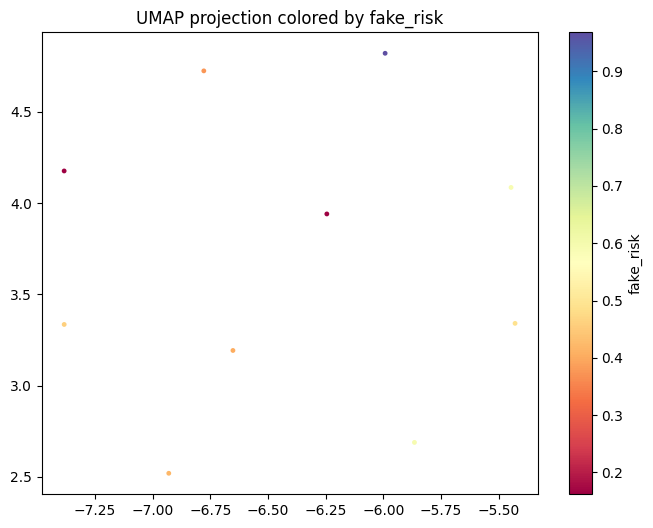

In [ ]:

import matplotlib.pyplot as plt
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
proj = reducer.fit_transform(embs)

plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], s=6, c=df['fake_risk'], cmap='Spectral')
plt.colorbar(label='fake_risk')
plt.title('UMAP projection colored by fake_risk')
plt.show()


In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=candidate_labels)

def predict_proba_for_lime(texts):
    outs = zero_shot(texts, candidate_labels=candidate_labels, hypothesis_template=hypothesis_template)
    probs = []
    for o in outs:
        d = dict(zip(o['labels'], o['scores']))
        probs.append([d.get(l, 0.0) for l in candidate_labels])
    return np.array(probs)

i = 0
exp = explainer.explain_instance(
    df['text'].iloc[i],
    predict_proba_for_lime,
    labels=[0,1],
    num_features=4,  
    num_samples=100    
)

print("Explanation for text index", i)
print(exp.as_list(label=0))


Explanation for text index 0
[(np.str_('anonymous'), 0.13836502096555534), (np.str_('Breaking'), 0.10598557512104069), (np.str_('made'), 0.06016461033792001), (np.str_('cheese'), 0.05649521482595256)]
